In [1]:
import numpy as np
import sklearn
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import os

%matplotlib inline

In [2]:
# SIZE = 28
meta = pd.read_csv('metadata.csv', delimiter=',')
# data = np.loadtxt(f'hmnist_{SIZE}_{SIZE}_L.csv', delimiter=',', skiprows=1, usecols=range(SIZE * SIZE))

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

skin_df = pd.read_csv('metadata.csv')

skin_df['path'] = skin_df['image_id'].map(lambda id: os.path.join("images", id + ".jpg"))
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

folder = "./baseline-lr0.001-epoch50-batchsize32"
# labels = list(meta.dx.unique())

In [3]:
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.2, random_state=42069)

x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.1, random_state=42069)

x_train = x_train.reshape(len(x_train),-1)

smote = SMOTE(k_neighbors=5, random_state=42069)
x_train, y_train = smote.fit_resample(x_train, y_train)
x_train = x_train.reshape(-1,75,100,3)

x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

2023-03-29 18:03:03.838754: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 18:03:04.383469: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/vande/miniconda3/envs/tf/lib/
2023-03-29 18:03:04.385473: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/vande/miniconda3/envs/tf/lib/
2023-03-29 18:03:04.385482: W tensorflow/compiler/tf2ten

In [4]:
import keras
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import keras_tuner

input_shape = (75, 100, 3)

def build_model(hp):
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), activation=hp.Choice("activation1", values=["leaky_relu", "sigmoid"]), input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float("dropout_rate", min_value=0, max_value=1, step=0.1)))
    if hp.Boolean("add_second_conv"):
        model.add(Conv2D(16, kernel_size=(3, 3), activation=hp.Choice("activation2", values=["leaky_relu", "sigmoid"])))
        model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float("dropout_rate2", min_value=0, max_value=1, step=0.1)))
    model.add(Flatten())
    model.add(Dense(hp.Int("denseness", min_value=16, max_value=128, step=16), activation='leaky_relu'))
    model.add(Dense(7, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log")), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective='val_accuracy',
    directory=folder,
    overwrite=True,
    max_trials=256,
    project_name='baseline-lr0.001-epoch50-batchsize32'
)

tuner.search_space_summary()

# model = build_model(keras_tuner.HyperParameters())
# model.summary()
# print(hp)

# history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_validate, y_validate))
tuner.search(x_train, y_train, epochs=10, validation_data=(x_validate, y_validate))


Trial 41 Complete [00h 01m 32s]
val_accuracy: 0.7094762921333313

Best val_accuracy So Far: 0.7406483888626099
Total elapsed time: 00h 54m 54s

Search: Running Trial #42

Value             |Best Value So Far |Hyperparameter
leaky_relu        |leaky_relu        |activation1
0.2               |0.4               |dropout_rate
True              |False             |add_second_conv
0.1               |0.6               |dropout_rate2
128               |64                |denseness
0.0060252         |0.00070052        |lr
sigmoid           |leaky_relu        |activation2

Epoch 1/10


2023-03-29 18:58:14.998383: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1059/1059 [==============================] - 10s 9ms/step - loss: 1.9346 - accuracy: 0.3742 - val_loss: 1.4296 - val_accuracy: 0.4501
Epoch 2/10
1059/1059 [==============================] - 8s 8ms/step - loss: 0.8835 - accuracy: 0.6688 - val_loss: 1.2586 - val_accuracy: 0.5636
Epoch 3/10
 869/1059 [=======================>......] - ETA: 1s - loss: 0.5939 - accuracy: 0.7838

KeyboardInterrupt: 

In [5]:
# GARBAGE COLLECT
import gc
gc.collect()


best_hps = tuner.get_best_hyperparameters(5)

del tuner
gc.collect()

model = build_model(best_hps[0])

print(best_hps[0])

history = model.fit(x_train, y_train, epochs=20, validation_data=(x_validate, y_validate))

Epoch 1/20


2023-03-29 18:58:47.617084: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1059/1059 [==============================] - 8s 7ms/step - loss: 0.7080 - accuracy: 0.7521 - val_loss: 1.0969 - val_accuracy: 0.5773
Epoch 2/20
1059/1059 [==============================] - 7s 7ms/step - loss: 0.2930 - accuracy: 0.8974 - val_loss: 1.0806 - val_accuracy: 0.6484
Epoch 3/20
1059/1059 [==============================] - 8s 7ms/step - loss: 0.2232 - accuracy: 0.9205 - val_loss: 1.1096 - val_accuracy: 0.6584
Epoch 4/20
1059/1059 [==============================] - 8s 7ms/step - loss: 0.1859 - accuracy: 0.9353 - val_loss: 1.0694 - val_accuracy: 0.7095
Epoch 5/20
1059/1059 [==============================] - 7s 7ms/step - loss: 0.1609 - accuracy: 0.9441 - val_loss: 1.1707 - val_accuracy: 0.7045
Epoch 6/20
1059/1059 [==============================] - 8s 7ms/step - loss: 0.1507 - accuracy: 0.9478 - val_loss: 1.1842 - val_accuracy: 0.7132
Epoch 7/20
1059/1059 [==============================] - 7s 7ms/step - loss: 0.1350 - accuracy: 0.9537 - val_loss: 1.1212 - val_accuracy: 0.7120
Epo

In [6]:
def plot_model_history(model_history):
    print(model_history.history.keys)
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    # axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])//10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    # axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

26/26 [==============================] - 0s 5ms/step - loss: 1.7904 - accuracy: 0.7319
Validation: accuracy = 0.731920  ;  loss = 1.790408
<built-in method keys of dict object at 0x7f36740abfc0>


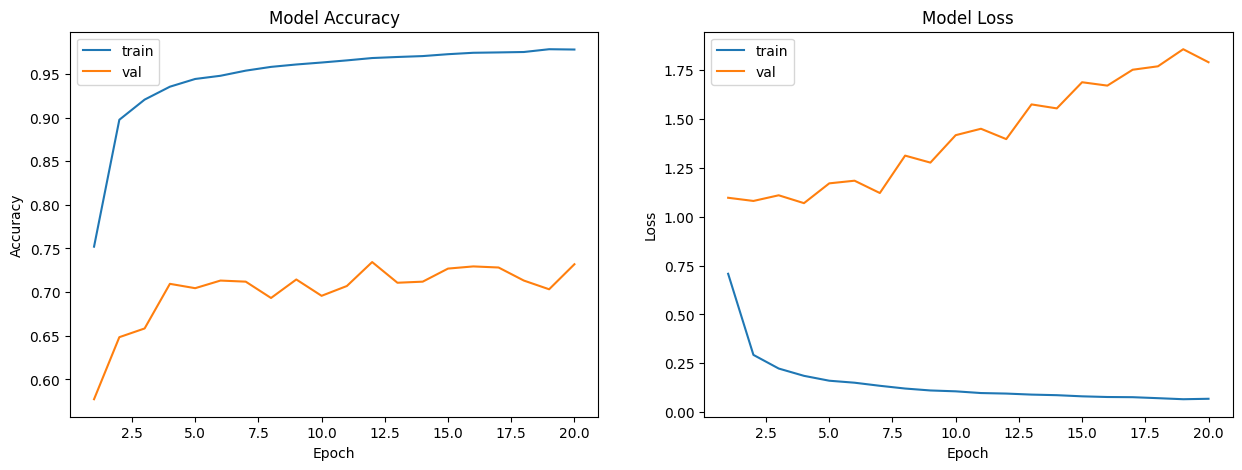

In [7]:
# test = model.evaluate(X_test, y_test)

# model = keras.models.load_model("./baseline-lr0.001-epoch150-batchsize32")
loss, accuracy = model.evaluate(x_validate, y_validate, verbose=1)
# loss_v, accuracy_v = model.evaluate(X_validate, y_validate, verbose=1)
# print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))

print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))
plot_model_history(history)

In [19]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = cm.round(2)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

63/63 [==============================] - 0s 2ms/step
(2003, 7)
63/63 [==============================] - 0s 5ms/step - loss: 1.8539 - accuracy: 0.7164
Test: accuracy = 0.716425  ;  loss = 1.853868


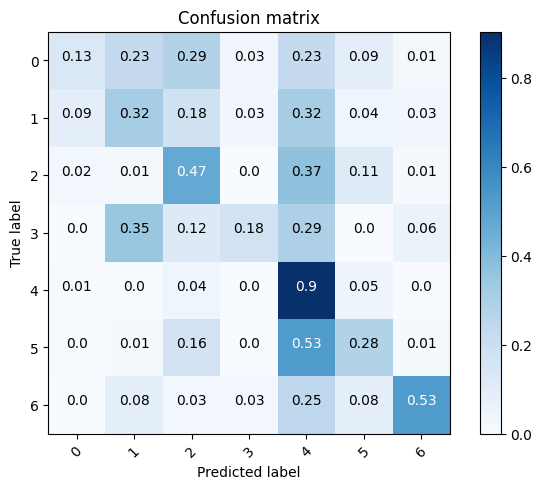

In [20]:
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(x_test)
print(Y_pred.shape)
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
Y_true = np.argmax(y_test, axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes, normalize='true')
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

loss_t, accuracy_t = model.evaluate(x_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy_t, loss_t))

In [10]:
from sklearn.metrics import classification_report

model.save(folder)

with open(folder + "/scores.txt", "w") as f:
    f.write(classification_report(Y_true, Y_pred.argmax(axis=1), target_names=labels))


INFO:tensorflow:Assets written to: ./baseline-lr0.001-epoch50-batchsize32/assets


INFO:tensorflow:Assets written to: ./baseline-lr0.001-epoch50-batchsize32/assets


NameError: name 'labels' is not defined

In [ ]:
gc.collect()